In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

In [17]:
#导入数据集
df_rating= pd.read_csv("../data/ml-1m/ratings.dat", sep="::", header=None, engine="python", 
                     names="UserID::MovieID::Rating::Timestamp".split("::"))

In [18]:
#随机采样
df_rating_sample = df_rating.sample(frac = 0.01)
df_rating_sample.head()

,UserID,MovieID,Rating,Timestamp
599152,3648,2808,2,994802583
487811,3001,1645,4,970619293
481946,2962,3360,2,978644772
594636,3619,1093,5,966583842
317425,1889,2990,4,989089408


In [19]:
#取出所有用户和电影ID
user = df_rating_sample["UserID"].unique()
movie = df_rating_sample["MovieID"].unique()
print(user.shape, movie.shape)

(3712,) (2303,)


In [23]:
#构造用户电影和评分的字典，为接下来构造共现矩阵做铺垫
rating_dict = defaultdict(int)

In [24]:
for index, row in df_rating_sample.iterrows():
    userid = row["UserID"]
    movieid = row["MovieID"]
    rating = row["Rating"]
    key = (userid, movieid)
    rating_dict[key] = rating
print(len(rating_dict))

10002


In [25]:
#构造共现矩阵，行索引代表用户id，列索引代表电影id
co_matrix = []
i = 0
j = 0
for i in range(len(user)):
    l = []
    for j in range(len(movie)):
        key = (user[i], movie[j])
        l.append(rating_dict[key])
    co_matrix.append(l)
print(len(co_matrix), len(co_matrix[0]), co_matrix[0][0])
np_matrix = np.array(co_matrix)

3712 2303 2


In [82]:
class MF(object):
    def __init__(self, k, m, n):
        self.User = tf.Variable(tf.random.normal((m, k), mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None))
        self.Item = tf.Variable(tf.random.normal((n, k), mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None))
    
    def __call__(self):
        return tf.matmul(self.User, tf.transpose(self.Item))

In [83]:
model = MF(12, np_matrix.shape[0], np_matrix.shape[1])

In [84]:
def loss(predicted_y, desired_y):
  return tf.reduce_mean(tf.square(predicted_y - desired_y))

In [123]:
#损失函数加正则化
def loss_regularization(predicted_y, desired_y, user_v, item_v):
  return tf.reduce_mean(tf.square(predicted_y - desired_y)) + (tf.reduce_sum(tf.square(user_v)) + tf.reduce_sum(tf.square(item_v)))

In [124]:
def train(model, real_outputs, learning_rate):
  with tf.GradientTape() as t:
    #current_loss = loss(model(), real_outputs)
    current_loss = loss_regularization(model(), real_outputs, model.User, model.Item)
  dUser, dItem = t.gradient(current_loss, [model.User, model.Item])
  model.User.assign_sub(learning_rate * dUser)
  model.Item.assign_sub(learning_rate * dItem)

In [125]:
epochs = range(10)
loss_list = []
for epoch in epochs:
  #current_loss = loss(model(), np_matrix)
  current_loss = loss_regularization(model(), np_matrix, model.User, model.Item)
  loss_list.append(current_loss)
  train(model, np_matrix, learning_rate=0.1)
  print('Epoch %2d: loss=%2.5f' %
        (epoch, current_loss))

Epoch  0: loss=680.52429
Epoch  1: loss=435.54056
Epoch  2: loss=278.75153
Epoch  3: loss=178.40675
Epoch  4: loss=114.18620
Epoch  5: loss=73.08508
Epoch  6: loss=46.78037
Epoch  7: loss=29.94537
Epoch  8: loss=19.17097
Epoch  9: loss=12.27536


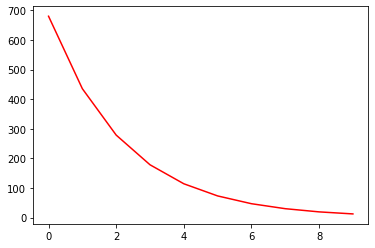

In [126]:
plt.plot(epochs, loss_list, 'r')
plt.show()

In [127]:
user_vector = model.User
item_vector = model.Item
print(user_vector.shape, item_vector.shape)
print(user_vector[:10])
print(item_vector[:10])

(3712, 12) (2303, 12)
tf.Tensor(
[[-1.20340912e-02  1.00606466e-02  5.25605446e-03 -1.30256712e-02
   8.71887617e-03 -4.99879057e-03 -2.37339921e-03 -8.48810747e-03
  -6.03483757e-03 -1.68493837e-02  1.42469313e-02 -3.38740437e-03]
 [ 1.34525672e-02  1.06363110e-02 -6.84150029e-03 -1.35153886e-02
  -9.39052334e-05  5.90960030e-03  1.28760617e-02 -5.47733996e-03
   3.93340457e-03 -3.57426750e-03 -1.32090971e-02 -1.63472537e-02]
 [-1.18230432e-02  1.03844632e-03  8.51116143e-03  2.22023595e-02
   1.04575288e-02 -1.03518169e-03 -5.10271813e-04  3.72156268e-03
  -1.09675890e-02 -2.46725418e-02  1.64364856e-02 -8.39038007e-03]
 [-8.96301121e-03  3.06968410e-02  2.43217740e-02  1.65761478e-04
   1.37555618e-02 -5.13131684e-03  1.69934183e-02 -1.80249568e-02
  -2.10093940e-03 -4.31997608e-03 -1.33270184e-02  8.63156188e-03]
 [ 1.34993391e-03 -3.70443845e-03 -6.42267801e-03 -4.84565180e-03
  -1.59242121e-03  8.63001868e-03  1.12665063e-02 -3.19903865e-02
  -8.78281798e-03  1.28479172e-02  3.10